In [1]:
##########################################################
# パッケージの読み込みとエイリアスの設定
##########################################################
using Revise, LinearAlgebra, LaTeXStrings, Plots, CSV, DataFrames, JLD2, Random, Statistics, Distributions
using TensorCrossInterpolation
import TensorCrossInterpolation as TCI
using Tensor_FixedSeedMC
import Tensor_FixedSeedMC as TCIMC

In [ ]:
function tci_oneshot(func, d, localdims, firstpivot, tol, maxiter)
    BLAS.set_num_threads(4)

    for isearch in 1:100
        p = TCI.optfirstpivot(func, localdims, firstpivot) # search optimal fist pivot
        if abs(func(p)) > abs(func(firstpivot))
            firstpivot = p
        end
    end

    # execute tci2
    qtt, ranks, errors = TCI.crossinterpolate2(
        Float64,
        func, 
        localdims, 
        [firstpivot], 
        tolerance = tol, 
        maxiter = maxiter, 
        verbosity = 1, 
        loginterval = 1,
        pivotsearch = :rook,
    )

    return qtt, errors
end  

tci_oneshot (generic function with 1 method)

In [ ]:
##########################################################
# パラメータの設定とグリッド生成
##########################################################

Random.seed!(1234)
# d_normals = randn(Float64, N_STEPS * N_PATHS)

num_nodes = 64
index_ = Int(num_nodes/2)

S0K_values = TCIMC.chebyshev_lobatto_nodes(90.0, 120.0, num_nodes)
implied_vol_values = TCIMC.chebyshev_lobatto_nodes(0.15, 0.25, num_nodes)
#T_values = TCIMC.calc_cheby_abscissas(0.1, 1.0, num_nodes)
r_values = TCIMC.chebyshev_lobatto_nodes(0.0, 0.1, num_nodes)
t_values = TCIMC.chebyshev_lobatto_nodes(5.0, 10.0, num_nodes)

65-element Vector{Float64}:
  5.0
  5.003011359487068
  5.012038183319508
  5.027058725088048
  5.048036798991924
  5.07492186701364
  5.107649160669478
  5.1461398370424485
  5.190301168721783
  5.240026767191392
  5.295196839129113
  5.35567847499932
  5.421325969243637
  ⋮
  9.64432152500068
  9.704803160870888
  9.759973232808608
  9.809698831278217
  9.853860162957552
  9.892350839330522
  9.92507813298636
  9.951963201008077
  9.972941274911953
  9.987961816680492
  9.996988640512932
 10.0

$$
d_{1/2} = \frac{\ln{(S_0 / K)} + (r \pm \sigma^2 / 2)(T-t)}{\sigma \sqrt{T-t} }
$$

In [4]:
T = 1.0
d1(S0K::Float64, σ::Float64, r::Float64,  t::Float64) = (log(S0K) + (r + σ^2/2) * (1.0 - t)) / (σ * (1.0 - t)^2)

function d1_ind_pre(
    bits::Vector{Int}, 
    S0K_values::Vector{Float64}, 
    implied_vol_values::Vector{Float64}, 
    #T_values::Vector{Float64}, 
    r_values::Vector{Float64}, 
    t_values::Vector{Float64}
    )
    S0K = S0K_values[bits[1]]
    σ = implied_vol_values[bits[2]]
    r = r_values[bits[3]]
    t = t_values[bits[4]]
    return d1(S0K, σ, r, t)
end 

d1_ind(bits) = d1_ind_pre(bits, S0K_values, implied_vol_values, r_values, t_values)

d1_ind (generic function with 1 method)

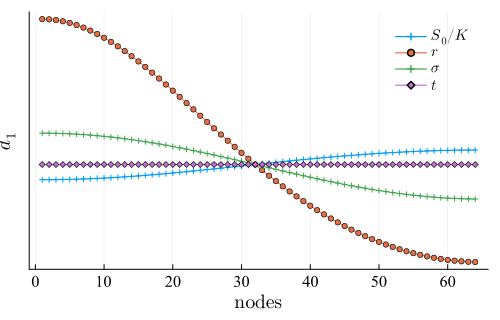

In [5]:
plot_d1 = plot(
    # yscale = :log,
    # xscale = :log,
    # title = L"\mathrm{QTT}~,~~d=10",
    xlabel = L"\mathrm{nodes}",
    ylabel = L"d_1",
    #markershape = :circle,
    titlefontsize = 17,
    legendfontsize = 10,
    tickfontsize = 10,
    xguidefont = 13,
    yguidefont = 13,
    #xlims = (0.6, 3.5),
    #xticks = 1:1:nbit*d-1,
    # ylims = (1, 2^(nbit*d*0.5)),
    yticks = [10^0, 10^2, 10^4, 10^6, 10^8],
    # legend = :inside,
    #size = (600, 450),
    #bottom_margin=Plots.Measures.Length(:mm, 3.0),
    bottom_margin=Plots.Measures.Length(:mm, 2.0),
    fontfamily = "Times New Roman",
    size = (500, 320),
    foreground_color_legend = nothing,
    background_color_legend = nothing,
)

plot!(
    plot_d1,
    [d1_ind([S0K_ind, index_, index_, index_]) for S0K_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"S_0 / K",
)

plot!(
    plot_d1,
    [d1_ind([index_, r_ind, index_,  index_]) for r_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"r",
)

plot!(
    plot_d1,
    [d1_ind([index_, index_, σ_ind,  index_]) for σ_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"\sigma",
)



plot!(
    plot_d1,
    [d1_ind([index_, index_, index_, index_]) for t_ind in 1:num_nodes],
    markershape = :auto,
    #seriestype = :scatter,
    #color = "red",
    markersize = 3,
    label = L"t",
)

In [ ]:
##########################################################
# TCI のキャッシュ関数設定とワンショット補間の実行
##########################################################
# 関数 abo は asian_barrier_option_tci のラッパー（引数はインデックス）
#abo(j) = asian_barrier_option_tci(j, price_matrix_mc)
# abo_(j) = asian_barrier_option_tci(j, price_matrix_mc)

d = 4
num_points = num_nodes+1
localdims_d1 = fill(num_points, d)
firstpivot_d1 = rand(1:num_points, d)
d1_cf = TCI.CachedFunction{Float64}(d1_ind, localdims_d1)
tol_mc = 1e-5
tol = tol_mc
maxiter = 10
tci_time = @elapsed begin
    tt_tci, errors_asianbarrier = tci_oneshot(d1_cf, d, localdims_d1, firstpivot_d1, tol, maxiter)
end
##########################################################

Found 0 global pivots
iteration = 1, rank = 3, error= 0.0, maxsamplevalue= 1.9760382261591856, nglobalpivot=0
Found 0 global pivots
iteration = 2, rank = 3, error= 0.0, maxsamplevalue= 1.9760382261591856, nglobalpivot=0
Found 0 global pivots
iteration = 3, rank = 3, error= 0.0, maxsamplevalue= 1.9760382261591856, nglobalpivot=0


2.934257417

In [7]:
# TCI後のTTを評価
n = num_nodes
price_matrix_tci_S0K = zeros(n)
price_matrix_ex_S0K = zeros(n)
price_matrix_tci_sigma = zeros(n)
price_matrix_ex_sigma = zeros(n)
price_matrix_tci_r = zeros(n)
price_matrix_ex_r = zeros(n)
price_matrix_tci_t = zeros(n)
price_matrix_ex_t = zeros(n)

for i in 1:n
    price_matrix_tci_S0K[i] = TCIMC._evaluate(tt_tci.sitetensors, [i, index_, index_, index_, index_])
    price_matrix_ex_S0K[i] = d1_ind([i, index_, index_, index_])
    price_matrix_tci_sigma[i] = TCIMC._evaluate(tt_tci.sitetensors, [index_, i, index_, index_, index_])
    price_matrix_ex_sigma[i] = d1_ind([index_, i, index_, index_])
    price_matrix_tci_r[i] = TCIMC._evaluate(tt_tci.sitetensors, [index_, index_, i, index_])
    price_matrix_ex_r[i] = d1_ind([index_, index_, i, index_])
    price_matrix_tci_t[i] =  TCIMC._evaluate(tt_tci.sitetensors, [index_, index_, index_, i])
    price_matrix_ex_t[i] = d1_ind([index_, index_, index_, i])
end

ab_error_S0K = abs.(price_matrix_tci_S0K .- price_matrix_ex_S0K)
ab_error_sigma = abs.(price_matrix_tci_sigma .- price_matrix_ex_sigma)
rel_error_S0K = abs.(price_matrix_tci_S0K .- price_matrix_ex_S0K) ./ price_matrix_ex_S0K
rel_error_sigma = abs.(price_matrix_tci_sigma .- price_matrix_ex_sigma) ./ price_matrix_ex_sigma
ab_error_r = abs.(price_matrix_tci_r .- price_matrix_ex_r)
ab_error_t = abs.(price_matrix_tci_t .- price_matrix_ex_t)


println("==== TCI ====")
println("Max absolute error for S0K    : ", maximum(ab_error_S0K))
println("Max absolute error for sigma  : ", maximum(ab_error_sigma))
println("Max relative error for S0K    : ", maximum(rel_error_S0K))
println("Max relative error for sigma  : ", maximum(rel_error_sigma))
@show maximum(ab_error_r)
@show maximum(ab_error_t)
:

==== TCI ====
Max absolute error for S0K    : 3.3306690738754696e-16
Max absolute error for sigma  : 2.220446049250313e-16
Max relative error for S0K    : 6.363567972764071e-16
Max relative error for sigma  : 4.058783247365968e-16
maximum(ab_error_r) = 2.220446049250313e-16
maximum(ab_error_t) = 2.220446049250313e-16


(::Colon) (generic function with 30 methods)

In [8]:
TCI.TensorTrain(tt_tci)

(::TensorTrain{Float64, 3}) (generic function with 1 method)

In [ ]:
#M_dct = TCIMC.dct_matrix(n)
M_dct = TCIMC.chebyshev_coeff_matrix_from_lobatto_sorted(num_nodes)


function compute_chebyshev_coeff_2(tt::TCI.TensorTrain{T}, A::Vector{<:AbstractMatrix{T}}) where {T}
    d = length(tt.sitetensors)
    @assert d == length(A) "長さ不一致: length(tt)=$d vs length(A)=$(length(A))"

    new_cores = Vector{Array{T,3}}(undef, d)

    for k in 1:d
        G = tt.sitetensors[k]               # (r_{k-1}, n_k, r_k)
        r1, n, r2 = size(G)
        Ak = A[k]                           # (p_k, n_k)
        p, nA = size(Ak)
        @assert n == nA "第$k: サイズ不一致 n_k=$n vs size(A[$k],2)=$nA"

        Gnew = zeros(T, r1, p, r2)          # (r_{k-1}, p_k, r_k)

        # 物理次元方向への線形変換:  ∀(i1,i3) : Gnew[i1,:,i3] = A[k] * G[i1,:,i3]
        @inbounds for i1 in 1:r1, i3 in 1:r2
            # y = A * x（x は長さ n のスライス）
            @views x = G[i1, :, i3]
            @views y = Gnew[i1, :, i3]
            mul!(y, Ak, x)                  # y = Ak * x
        end

        new_cores[k] = Gnew
    end

    # ★ 外部コンストラクタで作る（型パラメータは書かない）
    return TCI.TensorTrain(new_cores)
end



C_coeff_tensor_tci = compute_chebyshev_coeff_2(TCI.TensorTrain(tt_tci), fill(M_dct, d))

(::TensorTrain{Float64, 3}) (generic function with 1 method)

In [10]:
#M_dct = TCIMC.dct_matrix(n)
#C_coeff_tensor_tci = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_tci), fill(M_dct, d))
#C_coeff_tensor_svd = TCIMC.compute_chebyshev_coeff(TCI.TensorTrain(tt_svd), fill(M_dct, 2))

### 不明点

In [12]:
using Statistics, Random

#num_nodes = n
# num_nodes_S0 = 300
num_nodes_equiv = 100
S0K_values_equiv = collect(range(90.0, stop=120.0, length=num_nodes_equiv))
implied_vol_values_equiv = collect(range(0.15, stop=0.25, length=num_nodes_equiv))
r_values_equiv = collect(range(0.0, stop=0.1, length=num_nodes_equiv))
t_values_equiv = collect(range(5.0, stop=10.0, length=num_nodes_equiv))

# 全インデックスの組を作成して、ランダムに100点抽出
Random.seed!(1234)
# all_idx_pairs = [(i, j, k, l, m) for i in 1:num_nodes, j in 1:num_nodes, k in 1:num_nodes, l in 1:num_nodes, m in 1:num_nodes]
num_nodes_equiv = 80
all_idx_pairs = collect(Iterators.product(1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv, 1:num_nodes_equiv))
rand_idx_pairs = rand(vec(all_idx_pairs), 100)

# 解析解の関数
d1_ind_ex(bits) = d1_ind_pre(bits, S0K_values_equiv, implied_vol_values_equiv,  r_values_equiv, t_values_equiv)


price_dict_tci = Dict{NTuple{4, Int}, Float64}()
price_dict_ex = Dict{NTuple{4, Int}, Float64}()

for (i, j, l, m) in rand_idx_pairs
    s0_val   = S0K_values_equiv[i]
    vol_val  = implied_vol_values_equiv[j]
    r_val    = r_values_equiv[l]
    t_val    = t_values_equiv[m]

    #@show "s"

    weights = [
        TCIMC.cheb_basis_vector_weighted(90.0, 120.0, s0_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted(0.15, 0.25, vol_val, num_nodes ),
        TCIMC.cheb_basis_vector_weighted(0.0, 0.1, r_val, num_nodes),
        TCIMC.cheb_basis_vector_weighted(5.0, 10.0, t_val, num_nodes)
    ]

   # @show "d"

    c = 1  # 初期コアから更新
    left_cache  = TCIMC.compute_left_cache(C_coeff_tensor_tci, weights, c)
    right_cache = TCIMC.compute_right_cache(C_coeff_tensor_tci, weights, c)
    result_original = TCIMC.update_center(C_coeff_tensor_tci, left_cache, right_cache, weights[c], c)

    # TCI
    price_dict_tci[(i, j, l, m)] = result_original
    # 解析解
    #@show "c"
    #price_dict_ex[(i, j, l, m)] = d1_ind_ex([i, j, l, m])
    price_dict_ex[(i, j, l, m)] = d1(s0_val, vol_val, r_val, t_val)
    #@show "cc"
end

In [13]:
@show price_dict_ex
@show price_dict_tci
;

price_dict_ex = Dict((25, 12, 8, 57) => 0.5911461856122385, (61, 77, 17, 55) => 0.4289459850095352, (72, 4, 16, 27) => 1.0582178552025088, (72, 79, 62, 11) => 0.9300745076029608, (74, 22, 67, 52) => 0.5652627833685249, (12, 6, 31, 30) => 0.9297479908689463, (24, 16, 41, 16) => 1.1549346485302965, (62, 65, 50, 75) => 0.32103762232745137, (31, 66, 39, 57) => 0.4152285647401772, (43, 7, 45, 54) => 0.6114688784288842, (53, 14, 44, 72) => 0.45067977807526305, (74, 8, 61, 54) => 0.6044717509331982, (39, 24, 52, 68) => 0.4371750661711566, (29, 68, 75, 60) => 0.3680277002023663, (57, 4, 31, 20) => 1.1859650195730707, (75, 16, 64, 49) => 0.6199947774944784, (67, 40, 30, 72) => 0.39841514037013076, (65, 80, 20, 77) => 0.30721774794591833, (47, 79, 42, 22) => 0.7341930419067098, (31, 54, 48, 1) => 1.327559732607265, (77, 70, 66, 54) => 0.42150118939838754, (52, 36, 40, 71) => 0.40210230708657385, (18, 38, 22, 30) => 0.776281881929603, (4, 19, 10, 31) => 0.8565467435072035, (46, 10, 32, 39) => 0.7

### 誤差評価

In [14]:
using Statistics

# 絶対誤差、相対誤差を保存する辞書
abs_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()
rel_errors_tci = Dict{Tuple{Int,Int,Int,Int},Float64}()

for key in keys(price_dict_tci)
    ex_val = price_dict_ex[key]
    tci_val = price_dict_tci[key]
    
    abs_err = abs(ex_val - tci_val)
    rel_err = abs_err / abs(ex_val) 
    
    abs_errors_tci[key] = abs_err
    rel_errors_tci[key] = rel_err
end

# 統計量を計算
abs_error_vals = collect(values(abs_errors_tci))
rel_error_vals = collect(values(rel_errors_tci))

@show abs_error_vals
@show rel_error_vals

println("==== cheby ====")
println("Mean absolute error   : ", mean(abs_error_vals))
println("Max  absolute error   : ", maximum(abs_error_vals))
println("Mean relative error   : ", mean(rel_error_vals)) #
println("Max  relative error   : ", maximum(rel_error_vals)) #

abs_error_vals = [1.3100631690576847e-14, 2.220446049250313e-15, 5.551115123125783e-16, 3.774758283725532e-14, 1.354472090042691e-14, 2.886579864025407e-15, 2.042810365310288e-14, 6.661338147750939e-16, 3.941291737419306e-15, 1.3322676295501878e-15, 5.162537064506978e-15, 5.551115123125783e-16, 9.325873406851315e-15, 1.4988010832439613e-15, 1.9539925233402755e-14, 1.2101430968414206e-14, 1.9984014443252818e-15, 1.1102230246251565e-15, 1.9317880628477724e-14, 2.886579864025407e-15, 4.9960036108132044e-15, 8.770761894538737e-15, 1.2545520178264269e-14, 2.4424906541753444e-15, 2.886579864025407e-15, 2.6645352591003757e-15, 5.440092820663267e-15, 6.661338147750939e-16, 2.3314683517128287e-15, 1.2212453270876722e-15, 4.107825191113079e-15, 1.3433698597964394e-14, 5.440092820663267e-15, 9.492406860545088e-15, 5.10702591327572e-15, 7.882583474838611e-15, 7.882583474838611e-15, 1.5543122344752192e-15, 7.993605777301127e-15, 1.176836406102666e-14, 4.829470157119431e-15, 2.886579864025407e-15, 1